<a href="https://colab.research.google.com/github/DarekGit/FACES_DNN/blob/master/notebooks/06_03_FACES_DD_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [Spis treści](https://github.com/DarekGit/FACES_DNN/blob/master/notebooks/Praca_Dyplomowa.ipynb)

## [6. Porównanie modeli](06_00_Porownanie.ipynb)

### 6.3. Ewaluacja modeli na zbiorze FACES_DD

Instalacja Detectron2, pobranie datasetu i narzędzi

In [ ]:
!pip install gdown

import gdown
import os
url = 'https://drive.google.com/uc?export=download&id=1XwVm-2EMFdy9Zq39pKFr5UoSJvgTOm-7'
output = 'Faces_DD.zip'
gdown.download(url, output, False)
!unzip -o Faces_DD.zip
!rm Faces_DD.zip

# Download tools
!gdown https://drive.google.com/uc?id=1_9ydMZlTNFXBOMl16xsU8FSBmK2PW4lN -O tools.py
!git clone https://github.com/DarekGit/mAP.git

# mobilenet
!gdown https://drive.google.com/uc?id=1U0SVkSaSio4TBiXvF1QfTZI65WYpXpZ9
!unzip -qo mobilenet.zip
!rm -f mobilenet.zip

# install detectron2:

!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

Restart runtime to continue... 

In [ ]:
!nvidia-smi
from psutil import virtual_memory
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(virtual_memory().total / 1e9))

Fri Aug 21 12:45:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install facenet-pytorch
from facenet_pytorch import MTCNN

In [2]:
import time
from tqdm.notebook import tqdm
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


import gdown
from google.colab import drive
import os
import cv2
import random
import itertools
import shutil
import glob
import json
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import collections as mc

from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
import detectron2.utils.comm as comm
from detectron2.engine import DefaultPredictor, DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.structures import BoxMode
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

from mobilenet.utils import  add_mobilenet_config, build_mobilenetv2_fpn_backbone
from tools import annotations,output_Files
from mAP.mAP import mAP, plot_mAP

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1gIIUK518Ft9zi3VDVQZLRVozI-Hkpgt2'
output = 'Faces_DD_metrics.json'
gdown.download(url, output, False)
with open('Faces_DD_metrics.json','r') as f:
  Faces_DD=json.load(f)

In [5]:
Faces_DD[90]

{'depth': 3,
 'grey': False,
 'marks': [[1737.0, 486.0, 1818.0, 587.0],
  [1210.0, 1009.0, 1288.0, 1095.0],
  [55.0, 1015.0, 87.0, 1055.0]],
 'mean_std': [[120.13626572107435, 108.362532642924, 99.86483683920541],
  [69.45270481118739, 68.85858604223439, 72.785191769202]],
 'ori_size': [2304, 1728],
 'path': 'Faces_DD/2004/IMGP1068.JPG',
 'persons': ['KWD', 'ZBD', 'Other']}

## Konwersja danych uzyskanych z pliku Faces_DD_metrics.json do annotacji wymaganych przez Detectron2

In [55]:
def annotations_faces_dd(input_json=Faces_DD): 
  dataset_dicts = []
  for idx, item in enumerate(input_json):
    record = {}
    record["image_id"] = idx
    record['file_name'] = item['path']
    record['width'] = item['ori_size'][0]
    record['height'] = item['ori_size'][1]
    bbox = [i[:4] for i in item['marks']]
    annotation = []
    for box in bbox:
        anno = {}
        xmin, ymin, xmax, ymax = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        polygon = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
        polygon = list(itertools.chain.from_iterable(polygon))
        anno['category_id'] = 0 
        anno['iscrowd'] = 0
        anno['bbox'] = [xmin, ymin, xmax, ymax]
        anno['bbox_mode'] = BoxMode.XYXY_ABS
        anno['segmentation'] = [polygon]
        annotation.append(anno)
    record["annotations"] = annotation    
    dataset_dicts.append(record)
  return dataset_dicts

Zapis danych na Google drive

In [ ]:
OUTPUT_DIR_NAME = "FACES_DD_OUTPUT_DIR"
drive.mount('/content/drive')
OUTPUT_DIR_PATH = os.path.join("./drive/My Drive", OUTPUT_DIR_NAME)

if not os.path.exists(OUTPUT_DIR_PATH):
  os.makedirs(OUTPUT_DIR_PATH)
  print("\ncfg.OUTPUT_DIR =",OUTPUT_DIR_PATH) 
else: 
  print("\ncfg.OUTPUT_DIR =",OUTPUT_DIR_PATH)

## Modele do testu 

MobileNetV2

In [8]:
models_mnv2 = {
    # '800k' - parametry domyślne - jako punkt odniesienia
    '800k': {
        'config': 'FrozenBN',
        'pth': 'https://drive.google.com/uc?id=1-tqNKwZIFmkAbfJ1L2sibIO4PT_MwnVA',
        'weights_name': 'model_0799999.pth'},

    # 'BN_800k' - dodano BN - pokazanie wpływu BN przy małym batchu=2
    'BN_800k': {
        'config': 'BN',
        'pth': 'https://drive.google.com/uc?id=1-kRDjqkMk9qXbNfzVx09VE35YzgkP1AO',
        'weights_name': 'model_0799999.pth'},

    #'BN_Mish_V2_250+F_2_50k' - najlepszy wynik uczenie z Mish BN 250k + 50k z FrozenBN
    'BN_Mish_V2_250+F_2_50k': {
        'config': 'BN_Mish_V2F',
        'pth': 'https://drive.google.com/uc?id=1-I6YSAs9NrORI4cFISfK_-4Yhm1twfDi',
        'weights_name': 'model_0049999.pth'},
    
    # 'BN_Mish_V3_80+30k' - najszybsze uczenie 110k iteracji
    'BN_Mish_V3_80+_30k': {
        'config': 'BN_Mish_V3',
        'pth': 'https://drive.google.com/uc?id=1--bP5VPyqIrfrBxVZ5eLSsupIvBlQ8ef',
        'weights_name': 'model_0029999.pth'},
    }

Faster R-CNN

In [68]:
faster_rcnn_model = {
    'faster_rcnn_R_50_FPN_3x' : {
        'config': 'https://drive.google.com/uc?id=173XKeFyCXK909QA652WpEhQ3imlyDFKX',
        'config_file' : "faster_rcnn_R_50_FPN_3x.yaml",
        'pth': 'https://drive.google.com/uc?id=1-XGz6HOqJQWmDCJiJDbBl-FnK7ZxZu5z',
        'weights_name': 'model_0269999.pth' 
    },
    'scratch_faster_rcnn_R_50_FPN_gn' : {
        'config': 'https://drive.google.com/uc?id=1-IX6Dshhs-rin7m1lGtTl1xNaUQXK3kN',
        'config_file' : "scratch_faster_rcnn_R_50_FPN_gn.yaml",
        'pth': 'https://drive.google.com/uc?id=1-dqOloknew4wN0cD5xcFhbRlrA8rSHGt',
        'weights_name': 'model_0539999.pth' 
    }
}

MTCNN

In [10]:
mtcnn = MTCNN(image_size=224, margin=0, keep_all=True, device=device)

## Zestawy konfiguracji podstawowych dla modeli opartych na MobileNetV2

In [11]:
cfg_set = {
    'FrozenBN':'https://drive.google.com/uc?id=1rZFzJaR_g7uYuTguTdbUuCQYD4eXLeqw',
    'BN': 'https://drive.google.com/uc?id=1-doXtwe5iZHoqPzKGc2ZZbxj6Ebhxsn4',
    'BN_V2':'https://drive.google.com/uc?id=1wywB8UAaOO5KZx3IS35kV-rLsvJMIse6',
    'BN_Mish':'https://drive.google.com/uc?id=1-axV3KKg8-YiZZ7uDBh_2v181JoC9Nj3',
    'BN_Mish_V2':'https://drive.google.com/uc?id=1WoESx5RYvpapNicpSrmMoNJeE2GVm3zK',
    'BN_Mish_V3':'https://drive.google.com/uc?id=1-Kgd_2AS4EsD_ZPqP7SxkscyDjP-Qhnr',
    'BN_Mish_V2F':'https://drive.google.com/uc?id=1pCwyYCjIoduro2vIKMZi5HhlpaypH0_x',
    'R50_C4':'https://drive.google.com/uc?id=1-5P5Xyx5GM26p7g89CY-SSX0aluB7H9U',}

## DefaultPredictor dla modeli opartych na MobileNetV2

In [12]:
def cfg_write(cfg,cfg_all):
  for key in cfg_all.keys():
    if isinstance(cfg_all[key],dict): 
      cfg_write(cfg[key],cfg_all[key])
    else: cfg[key]=cfg_all[key]
  return cfg

def set_predictor(model_name=None, models_dict=models_mnv2, cfg_dict=cfg_set ,device='cuda', cfg_DATASETS_TEST=None):
  url = models_dict[model_name]['pth'] 
  out = models_dict[model_name]['weights_name']
  gdown.download(url, out, True)
  # model configuration
  url_cfg = cfg_dict[models_dict[model_name]['config']] 
  gdown.download(url_cfg, "temporary.json", True)
  with open('temporary.json','r') as f:
    cfg_all=json.load(f)
  cfg = get_cfg()
  add_mobilenet_config(cfg)
  cfg = cfg_write(cfg,cfg_all)
  cfg.MODEL.WEIGHTS = models_dict[model_name]['weights_name']
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
  cfg.MODEL.DEVICE=device
  if cfg_DATASETS_TEST is not None:
    cfg.DATASETS.TEST = (cfg_DATASETS_TEST, )

  return DefaultPredictor(cfg), cfg

## DefaultPredictor dla Faster-RCNN

In [13]:
def faster_predictor(model_name=None, models_dict=faster_rcnn_model, cfg_DATASETS_TEST=None):
  url = models_dict[model_name]['pth'] 
  out = models_dict[model_name]['weights_name']
  gdown.download(url, out, True)
  config = models_dict[model_name]['config']
  config_file = models_dict[model_name]['config_file']
  gdown.download(config, config_file, True)

  cfg = get_cfg()

  cfg.merge_from_file(config_file)
  cfg.MODEL.WEIGHTS = out
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
  cfg.MODEL.DEVICE='cuda'
  if cfg_DATASETS_TEST is not None:
    cfg.DATASETS.TEST = (cfg_DATASETS_TEST, )
  return DefaultPredictor(cfg), cfg

## Funkcja pomiaru czasu ewaluacji modelu

In [14]:
def time_measurement(predictor, dataset):
  time_ = []
  for item in tqdm(dataset):
    start_ = time.time()
    img = cv2.imread(item["file_name"])
    if str(predictor) == "mtcnn":
      outputs = mtcnn.detect(img)
    else :
      outputs = predictor(img)
    diff = time.time() - start_
    time_.append(diff)
  # Total time
  total_time = np.array(time_).sum()
  # Mean time
  mean_diff = np.array(time_).mean()
  # Frames per second 
  fps = 1 / mean_diff
  print("Total time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))
  return {"total_time": total_time, "mean_diff": mean_diff, "fps": fps}

## Funkcja do ewaluacji modelu 

In [15]:
def predict_on_val(dataset, predictor, model_name):
    gbxs=[]
    dbxs=[]
    dset=dataset
    if 'annotations' in dataset[0].keys():  
      dset=[]
      for r in dataset:
        dset.append({'path' : r['file_name'],'marks' : [b['bbox'] for b in r['annotations']],
                     'persons': ['' for b in r['annotations']]})

    for item in tqdm(dset):
        im = cv2.imread(item["path"])
        outputs = predictor(im)
        pbxs = outputs['instances'].pred_boxes.tensor.tolist()
        pconfs = outputs['instances'].scores.tolist()
        dbx=[[*(np.array(bx)+0.5).astype('int'),pconfs[i]] for i,bx in enumerate(pbxs)]
        dbxs.append(dbx)
        gbxs.append(item['marks'])
    
    return {'gbxs':gbxs,'dbxs':dbxs,'metric':dset} 

## Funkcja do ewaluacji MTCNN 

In [16]:
def mtcnn_detect(dataset, model, model_name = "MTCNN"):
    gbxs=[]
    dbxs=[]
    dset=dataset
    if 'annotations' in dataset[0].keys():  
      dset=[]
      for r in dataset:
        dset.append({'path' : r['file_name'],'marks' : [b['bbox'] for b in r['annotations']],
                     'persons': ['' for b in r['annotations']]})

    for item in tqdm(dset):
        im = cv2.imread(item["path"])
        pbxs, pconfs  = model.detect(im)

        if type(pbxs)!=np.ndarray: 
          pbxs=[]
          pconfs=[]

        dbx=[[*(np.array(bx)+0.5).astype('int'),pconfs[i]] for i,bx in enumerate(pbxs)]
        dbxs.append(dbx)
        gbxs.append(item['marks'])
    
    return {'gbxs':gbxs,'dbxs':dbxs,'metric':dset}

## Funkcje do ewaluacji modelu na zbiorze testowym WIDER FACE i umożliwiające zapis wyników do pliku

In [17]:
def read_wider_face_test_filelist(path='WIDER/wider_face_split/'):
  full_path = path+"wider_face_test_filelist.txt"
  if os.path.exists(full_path):
    test_files = []
    with open(full_path, 'r') as f:
      for row in f:
        test_files.append(row.split('\n')[0])
    return test_files

In [18]:
def predict_on_test(file_list, predictor, model_name, path="WIDER/WIDER_test/images/"):
  output_list = []
  for item in tqdm(file_list):
    if os.path.exists(path+item):
      record = {}
      img = cv2.imread(path+item)
      outputs = predictor(img)
      pbxs = outputs['instances'].pred_boxes.tensor.tolist()
      pconfs = outputs['instances'].scores.tolist()
      dbx=[[*(np.array(bx)+0.5).astype('int'),pconfs[i]] for i,bx in enumerate(pbxs)]
      record['file_name'] = item
      record['faces'] = len(dbx)
      record["bbox"] = dbx
    output_list.append(record)
  return output_list

In [19]:
def dict_to_file(dic, path):
    f = open(path,'w')
    f.write(str(dic))
    f.close()

def dict_from_file(filename):
    f = open(filename,'r')
    data=f.read()
    f.close()
    return eval(data)

## Pomiar czasu interferencji modeli na zbiorze walidacyjnym

In [20]:
dataset = annotations_faces_dd(Faces_DD)

In [21]:
time_measurement_results = {}
for model in models_mnv2:
  print(model)
  predictor, _ = set_predictor(model)
  time_measurement_results[model] = time_measurement(predictor, dataset=dataset)

print(time_measurement_results)

800k



Total time(sec): 211.47, Average(sec):0.23, fps:4.37

BN_800k



Total time(sec): 210.41, Average(sec):0.23, fps:4.40

BN_Mish_V2_250+F_2_50k



Total time(sec): 327.35, Average(sec):0.35, fps:2.83

BN_Mish_V3_80+_30k



Total time(sec): 333.37, Average(sec):0.36, fps:2.77

{'800k': {'total_time': 211.47324109077454, 'mean_diff': 0.22861972009813464, 'fps': 4.374075865243609}, 'BN_800k': {'total_time': 210.41467332839966, 'mean_diff': 0.22747532251718883, 'fps': 4.396081249316336}, 'BN_Mish_V2_250+F_2_50k': {'total_time': 327.3470287322998, 'mean_diff': 0.3538886797105944, 'fps': 2.825747353144461}, 'BN_Mish_V3_80+_30k': {'total_time': 333.37197613716125, 'mean_diff': 0.36040213636449864, 'fps': 2.7746783359481353}}


In [22]:
for model in faster_rcnn_model:
  print(model)
  predictor, _ = faster_predictor(model)
  time_measurement_results[model] = time_measurement(predictor, dataset=dataset)

faster_rcnn_R_50_FPN_3x



Total time(sec): 234.00, Average(sec):0.25, fps:3.95

scratch_faster_rcnn_R_50_FPN_gn



Total time(sec): 241.16, Average(sec):0.26, fps:3.84



In [24]:
time_measurement_results["MTCNN"] = time_measurement(mtcnn, dataset=dataset)


Total time(sec): 475.08, Average(sec):0.51, fps:1.95



In [25]:
time_measurement_results

{'800k': {'fps': 4.374075865243609,
  'mean_diff': 0.22861972009813464,
  'total_time': 211.47324109077454},
 'BN_800k': {'fps': 4.396081249316336,
  'mean_diff': 0.22747532251718883,
  'total_time': 210.41467332839966},
 'BN_Mish_V2_250+F_2_50k': {'fps': 2.825747353144461,
  'mean_diff': 0.3538886797105944,
  'total_time': 327.3470287322998},
 'BN_Mish_V3_80+_30k': {'fps': 2.7746783359481353,
  'mean_diff': 0.36040213636449864,
  'total_time': 333.37197613716125},
 'MTCNN': {'fps': 1.9470443310310237,
  'mean_diff': 0.5135989890227447,
  'total_time': 475.0790648460388},
 'faster_rcnn_R_50_FPN_3x': {'fps': 3.953065997866982,
  'mean_diff': 0.2529682025393924,
  'total_time': 233.995587348938},
 'scratch_faster_rcnn_R_50_FPN_gn': {'fps': 3.8355887628907244,
  'mean_diff': 0.26071616688290156,
  'total_time': 241.16245436668396}}

Porównanie wyników 

In [26]:
df_time_measurement_results = pd.DataFrame.from_dict(time_measurement_results, orient='index').sort_values(by=['total_time'])
df_time_measurement_results

,total_time,mean_diff,fps
BN_800k,210.414673,0.227475,4.396081
800k,211.473241,0.228620,4.374076
faster_rcnn_R_50_FPN_3x,233.995587,0.252968,3.953066
scratch_faster_rcnn_R_50_FPN_gn,241.162454,0.260716,3.835589
BN_Mish_V2_250+F_2_50k,327.347029,0.353889,2.825747
BN_Mish_V3_80+_30k,333.371976,0.360402,2.774678
MTCNN,475.079065,0.513599,1.947044


Zapis wyników 

In [27]:
time_measurement_results = df_time_measurement_results.to_json(orient="table")

output_file_name = "time_measurement_results.json"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)

with open(output_file, 'w') as f:
  json.dump(time_measurement_results, f, indent=4)  

## Ewaluacja modeli na zbiorze walidacyjnym i mAP liczone funkcją Darka

In [75]:
dataset = annotations_faces_dd(Faces_DD)

In [76]:
pred = {}
for model in models_mnv2:
  print(model)
  predictor, cfg = set_predictor(model)
  pred[model] = predict_on_val(dataset ,predictor, model)
  # save to Google drive 
  output_file_name = f"unified_mAP_{model}"
  output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
  dict_to_file(pred[model], output_file)

800k



BN_800k



BN_Mish_V2_250+F_2_50k



BN_Mish_V3_80+_30k


In [77]:
for model in faster_rcnn_model:
  print(model)
  predictor, cfg = faster_predictor(model)
  pred[model] = predict_on_val(dataset ,predictor, model)
    
  # save to Google drive 
  output_file_name = f"unified_mAP_{model}"
  output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
  dict_to_file(pred[model], output_file)

faster_rcnn_R_50_FPN_3x



scratch_faster_rcnn_R_50_FPN_gn


In [78]:
model = "MTCNN"
pred[model] = mtcnn_detect(dataset , mtcnn , model)
output_file_name = f"unified_mAP_{model}"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(pred[model], output_file)

## Wykresy mAP dla testowanych modeli

In [79]:
def model_mAP(pdict, model_name, title=""):
  m, d = mAP(gbxs=pdict[model_name]['gbxs'], dbxs=pdict[model_name]['dbxs'], data=True)
  output_file_name = f"unified_mAP_{title}_{model_name}"
  plot_mAP(m,d,['All 0.50','mAP','large','medium','small'],1,title+model_name,file=f"unified_mAP_{title}_{model_name}")
  return m,d

In [80]:
all_models_mAP = {}
pred.keys()

dict_keys(['800k', 'BN_800k', 'BN_Mish_V2_250+F_2_50k', 'BN_Mish_V3_80+_30k', 'faster_rcnn_R_50_FPN_3x', 'scratch_faster_rcnn_R_50_FPN_gn', 'MTCNN'])

## Model: 800k

Model: 800k
All 0.50:   AP: 73.14%   Recall: 75.91%   IoU: 0.5
large   :   AP: 77.76%   Recall: 79.54%   IoU: 0.5
medium  :   AP: 63.38%   Recall: 68.40%   IoU: 0.5
small   :   AP: 41.04%   Recall: 50.43%   IoU: 0.5
mAP     :   AP: 48.10%   Recall: 52.63%   IoU: 0.5 - 0.95


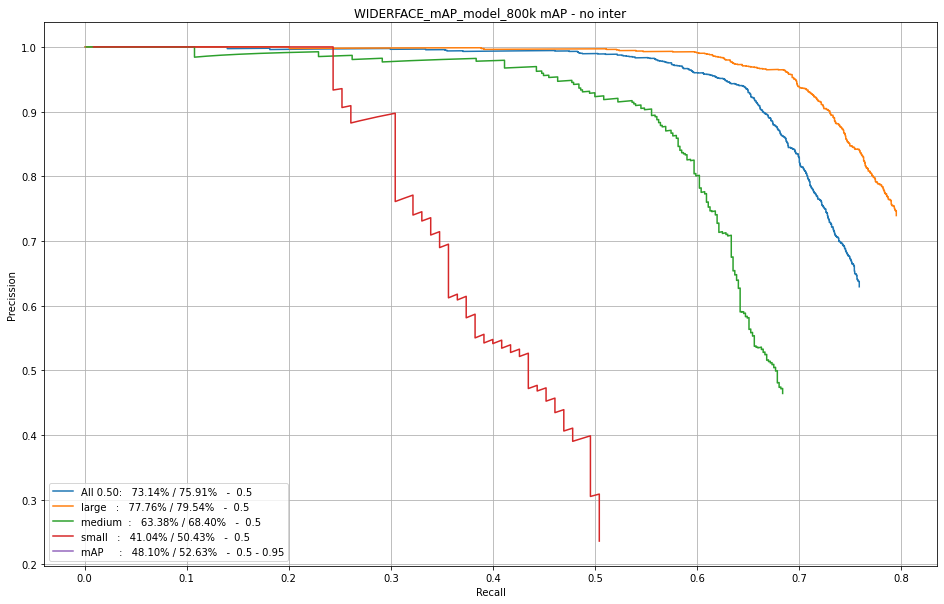

In [81]:
modelshow = list(pred.keys())[0]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="WIDERFACE_mAP_model_")

## Model: BN_800k


Model: BN_800k
All 0.50:   AP: 89.82%   Recall: 90.86%   IoU: 0.5
large   :   AP: 95.78%   Recall: 96.30%   IoU: 0.5
medium  :   AP: 74.87%   Recall: 78.99%   IoU: 0.5
small   :   AP: 52.55%   Recall: 55.65%   IoU: 0.5
mAP     :   AP: 61.24%   Recall: 65.38%   IoU: 0.5 - 0.95


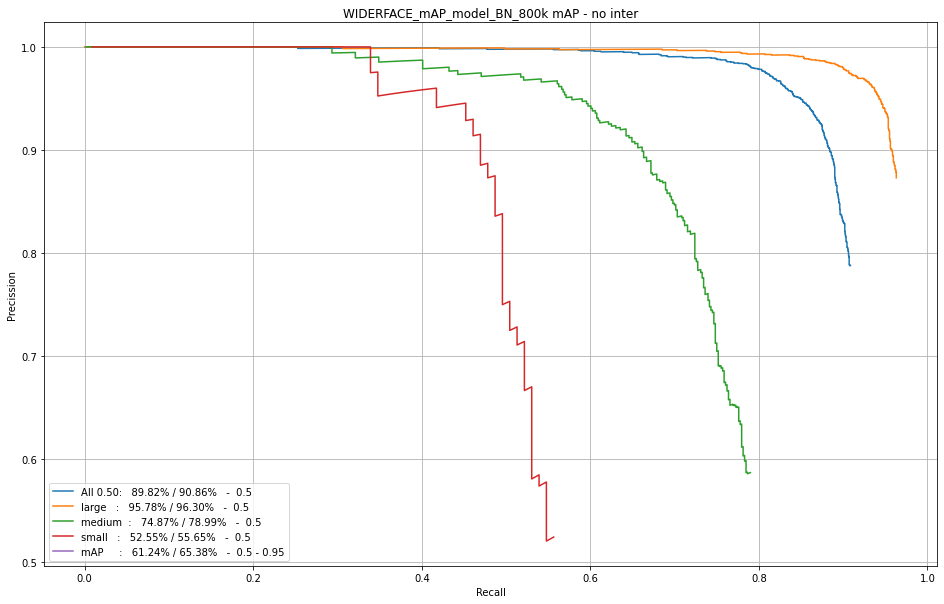

In [82]:
modelshow = list(pred.keys())[1]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="WIDERFACE_mAP_model_")

## Model: BN_Mish_V2_250+F_2_50k

Model: BN_Mish_V2_250+F_2_50k
All 0.50:   AP: 92.96%   Recall: 93.83%   IoU: 0.5
large   :   AP: 97.28%   Recall: 97.65%   IoU: 0.5
medium  :   AP: 82.15%   Recall: 85.94%   IoU: 0.5
small   :   AP: 60.99%   Recall: 66.96%   IoU: 0.5
mAP     :   AP: 62.65%   Recall: 67.11%   IoU: 0.5 - 0.95


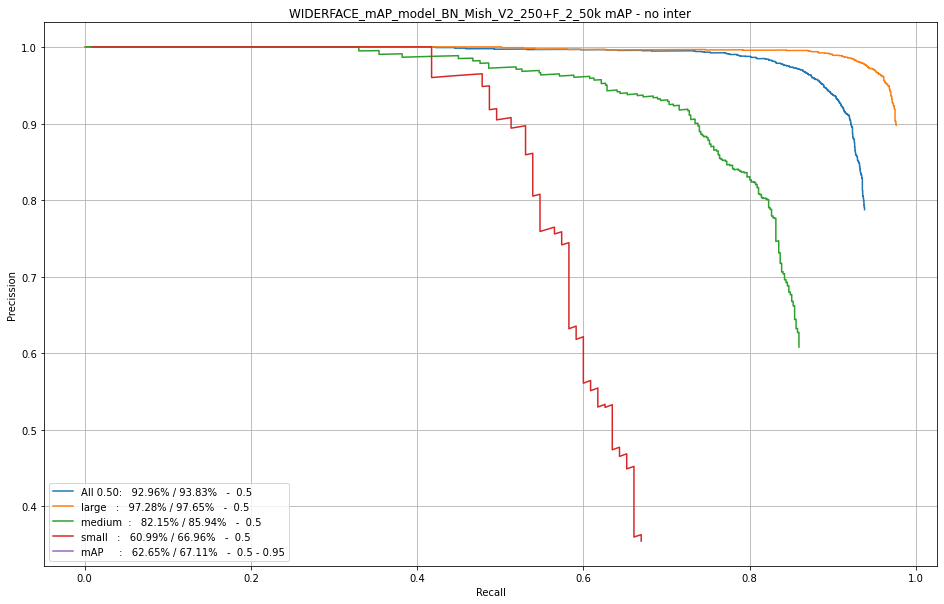

In [83]:
modelshow = list(pred.keys())[2]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="WIDERFACE_mAP_model_")

## Model: BN_Mish_V3_80+_30k

Model: BN_Mish_V3_80+_30k
All 0.50:   AP: 91.78%   Recall: 92.60%   IoU: 0.5
large   :   AP: 96.71%   Recall: 97.15%   IoU: 0.5
medium  :   AP: 81.52%   Recall: 84.72%   IoU: 0.5
small   :   AP: 50.67%   Recall: 53.04%   IoU: 0.5
mAP     :   AP: 62.84%   Recall: 67.39%   IoU: 0.5 - 0.95


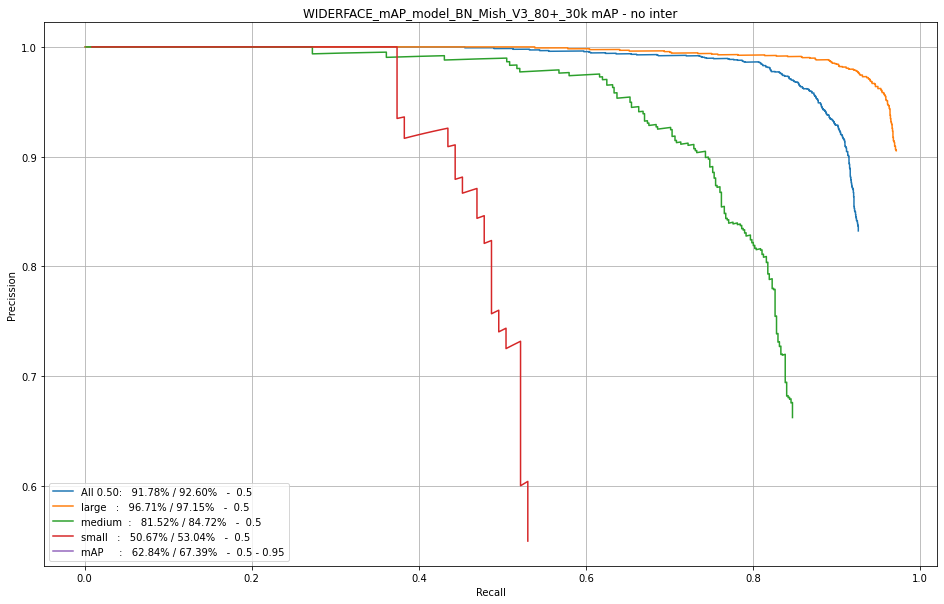

In [84]:
modelshow = list(pred.keys())[3]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="WIDERFACE_mAP_model_")

## Model: faster_rcnn_R_50_FPN_3x

Model: faster_rcnn_R_50_FPN_3x
All 0.50:   AP: 89.79%   Recall: 91.04%   IoU: 0.5
large   :   AP: 96.48%   Recall: 97.00%   IoU: 0.5
medium  :   AP: 71.99%   Recall: 78.30%   IoU: 0.5
small   :   AP: 46.51%   Recall: 51.30%   IoU: 0.5
mAP     :   AP: 60.22%   Recall: 65.02%   IoU: 0.5 - 0.95


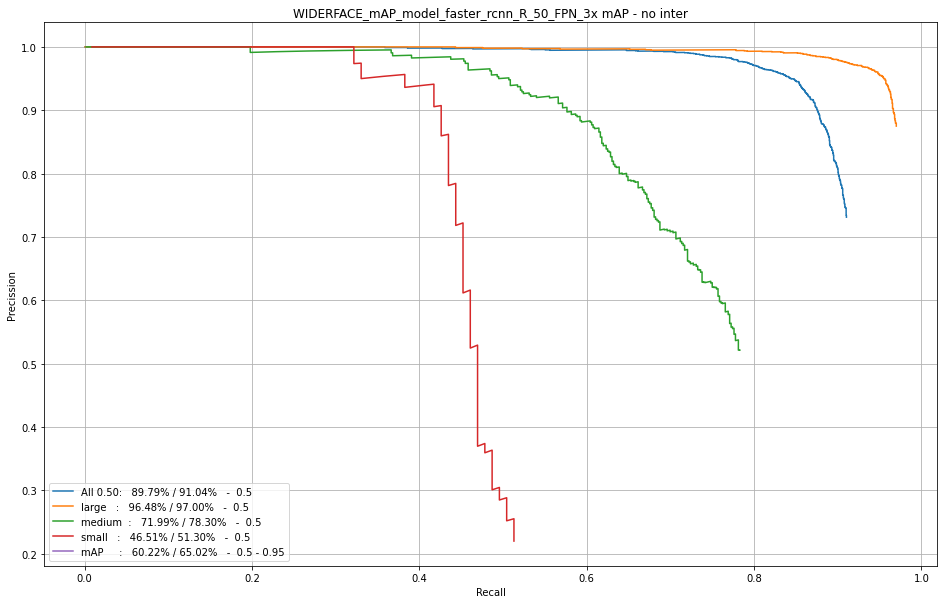

In [85]:
modelshow = list(pred.keys())[4]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="WIDERFACE_mAP_model_")

## Model: scratch_faster_rcnn_R_50_FPN_gn

Model: scratch_faster_rcnn_R_50_FPN_gn
All 0.50:   AP: 91.69%   Recall: 92.90%   IoU: 0.5
large   :   AP: 96.39%   Recall: 97.05%   IoU: 0.5
medium  :   AP: 80.70%   Recall: 85.42%   IoU: 0.5
small   :   AP: 54.34%   Recall: 58.26%   IoU: 0.5
mAP     :   AP: 58.43%   Recall: 65.67%   IoU: 0.5 - 0.95


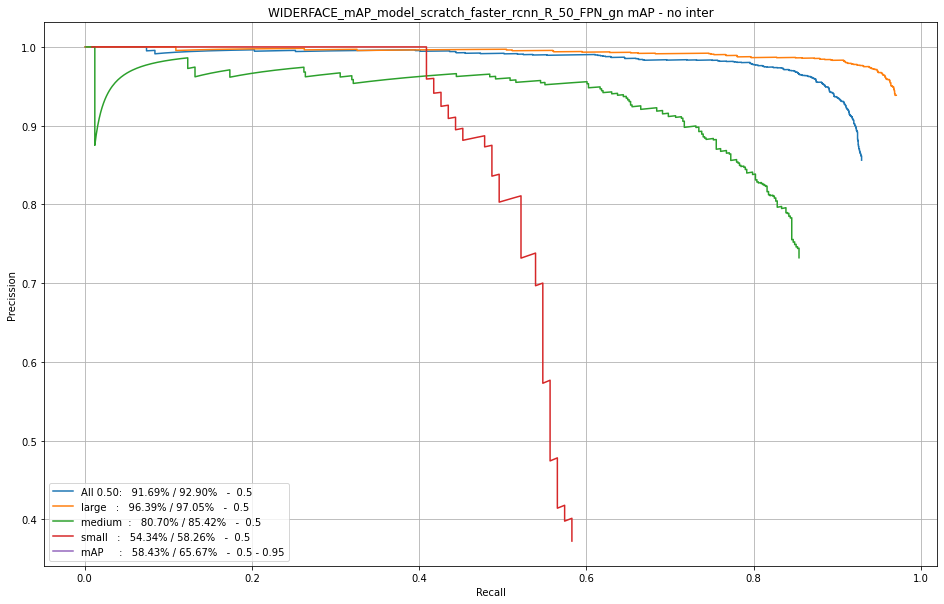

In [86]:
modelshow = list(pred.keys())[5]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="WIDERFACE_mAP_model_")

## Model: MTCNN

Model: MTCNN
All 0.50:   AP: 62.86%   Recall: 63.57%   IoU: 0.5
large   :   AP: 66.09%   Recall: 66.23%   IoU: 0.5
medium  :   AP: 54.21%   Recall: 56.42%   IoU: 0.5
small   :   AP: 46.41%   Recall: 53.04%   IoU: 0.5
mAP     :   AP: 46.52%   Recall: 50.46%   IoU: 0.5 - 0.95


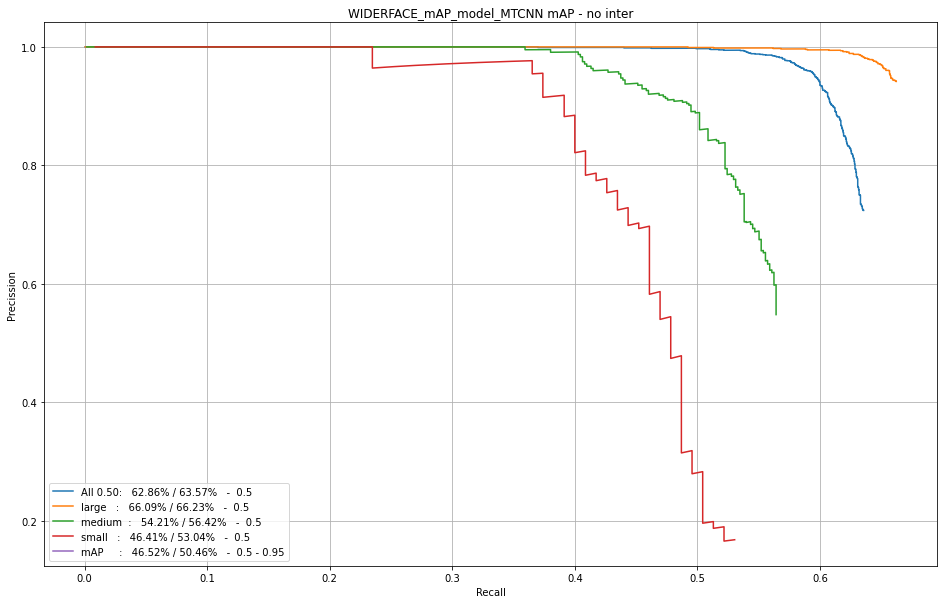

In [87]:
modelshow = list(pred.keys())[6]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="WIDERFACE_mAP_model_")

In [88]:
!mv unified_mAP*.png ./drive/'My Drive'/FACES_DD_OUTPUT_DIR/

Zapis wyników 

In [89]:
output_file_name = "all_models_mAP"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(all_models_mAP, output_file)

In [90]:
modeldict = {}
DD_mAP = {}

for item in all_models_mAP.keys():
  for i in all_models_mAP[item][0].keys():
    modeldict[i] =  {
        "AP" : all_models_mAP[item][0][i][0],
        "Recall" : all_models_mAP[item][0][i][1],
        "IoU" : all_models_mAP[item][0][i][2],
    }
  DD_mAP[item] = modeldict 

In [91]:
output_file_name = "DD_mAP_all_models"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(DD_mAP, output_file)

In [92]:
from collections import OrderedDict

DD_mAP2 = OrderedDict()

for item in all_models_mAP.keys():
  DD_mAP2[item] = ({i:all_models_mAP[item][0][i][0] for i in ['mAP', 'All 0.50','large','medium','small']})

df_unified_mAP = pd.DataFrame.from_dict(DD_mAP2, orient='index').sort_values(by=['All 0.50'], ascending=False)
df_unified_mAP

,mAP,All 0.50,large,medium,small
BN_Mish_V2_250+F_2_50k,0.626479,0.929601,0.972834,0.821471,0.609895
BN_Mish_V3_80+_30k,0.628391,0.917763,0.967092,0.815184,0.506664
scratch_faster_rcnn_R_50_FPN_gn,0.584328,0.916883,0.963875,0.806975,0.543409
BN_800k,0.612444,0.898214,0.957840,0.748719,0.525535
faster_rcnn_R_50_FPN_3x,0.602236,0.897930,0.964779,0.719939,0.465102
800k,0.481014,0.731359,0.777617,0.633790,0.410361
MTCNN,0.465178,0.628649,0.660909,0.542096,0.464101


In [93]:
df_unified_mAP_results = df_unified_mAP.to_json(orient="table")

output_file_name = "unified_mAP_dataframe.json"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)

with open(output_file, 'w') as f:
  json.dump(df_unified_mAP_results, f, indent=4)  

In [94]:
with open(output_file) as data_file:
    data_loaded = json.load(data_file)
pd.read_json(data_loaded, orient="table" )

,mAP,All 0.50,large,medium,small
BN_Mish_V2_250+F_2_50k,0.626479,0.929601,0.972834,0.821471,0.609895
BN_Mish_V3_80+_30k,0.628391,0.917763,0.967092,0.815184,0.506664
scratch_faster_rcnn_R_50_FPN_gn,0.584328,0.916883,0.963875,0.806975,0.543409
BN_800k,0.612444,0.898214,0.957840,0.748719,0.525535
faster_rcnn_R_50_FPN_3x,0.602236,0.897930,0.964779,0.719939,0.465102
800k,0.481014,0.731359,0.777617,0.633790,0.410361
MTCNN,0.465178,0.628649,0.660909,0.542096,0.464101


# Ewaluacja na WIDER FACE z wykorzystaniem COCOEvaluator i inference_on_dataset

In [48]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [57]:
val = annotations_faces_dd(Faces_DD)
test = annotations_faces_dd(Faces_DD)

In [58]:
for d in ["test", "val"]:
  DatasetCatalog.register("faces_" + d, lambda d=d: test if d == "test" else val)
  MetadataCatalog.get("faces_" + d).set(thing_classes = ['face'])

faces_metadata2 = MetadataCatalog.get("faces_test")

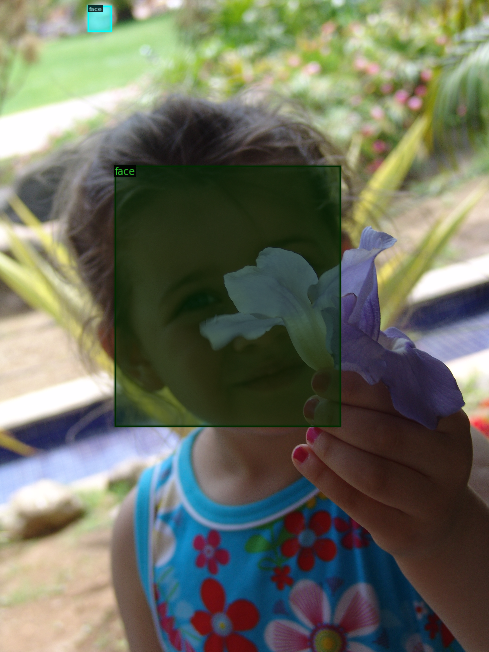

In [62]:
dataset_dicts = annotations_faces_dd(Faces_DD)
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=faces_metadata2, scale=0.2)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [63]:
AP_VAL = {}
drive.mount('/content/drive')
OUTPUT_DIR_NAME = "FACES_DD_OUTPUT_DIR"
OUTPUT_DIR_PATH = os.path.join("./drive/My Drive", OUTPUT_DIR_NAME)

if not os.path.exists(OUTPUT_DIR_PATH):
  os.makedirs(OUTPUT_DIR_PATH)

for model in models_mnv2:
  print(model)
  destination = os.path.join(OUTPUT_DIR_PATH, model)
  if not os.path.exists(destination):
    os.makedirs(destination)
  predictor, cfg = set_predictor(model, cfg_DATASETS_TEST="faces_test")
  print(destination)

  evaluator = COCOEvaluator(cfg.DATASETS.TEST[0], cfg, True, output_dir=destination)
  val_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
  inference_on_dataset(predictor.model, val_loader, evaluator)
  AP_VAL[model] = evaluator.evaluate()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
800k
./drive/My Drive/FACES_DD_OUTPUT_DIR/800k
[08/21 15:33:27 d2.evaluation.coco_evaluation]: 'faces_test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[08/21 15:33:27 d2.data.datasets.coco]: Converting annotations of dataset 'faces_test' to COCO format ...)
[08/21 15:33:27 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[08/21 15:33:28 d2.data.datasets.coco]: Conversion finished, #images: 925, #annotations: 2690
[08/21 15:33:28 d2.data.datasets.coco]: Caching COCO format annotations at './drive/My Drive/FACES_DD_OUTPUT_DIR/800k/faces_test_coco_format.json' ...
[08/21 15:33:28 d2.data.common]: Serializing 925 elements to byte tensors and concatenating them all ...
[08/21 15:33:28 d2.data.common]: Serialized dataset takes 0.35 MiB
[08/21 15:33:28 d2.data.dataset_mapper]: Augmentations used

In [70]:
for model in faster_rcnn_model:
  print(model)
  destination = os.path.join(OUTPUT_DIR_PATH, model)
  if not os.path.exists(destination):
    os.makedirs(destination)
  predictor, cfg = faster_predictor(model, cfg_DATASETS_TEST="faces_test")
  print(destination)

  evaluator = COCOEvaluator(cfg.DATASETS.TEST[0], cfg, True, output_dir=destination)
  val_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
  inference_on_dataset(predictor.model, val_loader, evaluator)
  AP_VAL[model] = evaluator.evaluate()

faster_rcnn_R_50_FPN_3x
./drive/My Drive/FACES_DD_OUTPUT_DIR/faster_rcnn_R_50_FPN_3x
[08/21 15:46:18 d2.data.common]: Serializing 925 elements to byte tensors and concatenating them all ...
[08/21 15:46:18 d2.data.common]: Serialized dataset takes 0.35 MiB
[08/21 15:46:18 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/21 15:46:18 d2.evaluation.evaluator]: Start inference on 925 images
[08/21 15:46:20 d2.evaluation.evaluator]: Inference done 11/925. 0.0845 s / img. ETA=0:02:04
[08/21 15:46:26 d2.evaluation.evaluator]: Inference done 49/925. 0.0790 s / img. ETA=0:02:05
[08/21 15:46:31 d2.evaluation.evaluator]: Inference done 92/925. 0.0776 s / img. ETA=0:01:49
[08/21 15:46:36 d2.evaluation.evaluator]: Inference done 129/925. 0.0768 s / img. ETA=0:01:46
[08/21 15:46:41 d2.evaluation.evaluator]: Inference done 170/925. 0.0769 s / img. ETA=0:01:39
[08/21 15:46:46 d2.evaluation.evaluator]: 

In [71]:
output_file_name = "AP_VAL_COCOEvaluator"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(AP_VAL, output_file)

Porównanie wyników

In [72]:
AP_FACES_DD = {}
for item in AP_VAL.keys():
  AP_FACES_DD[item] = AP_VAL[item]['bbox']

df_AP_FACES_DD = pd.DataFrame.from_dict(AP_FACES_DD, orient='index').sort_values(by=['AP'], ascending=False)

In [73]:
df_AP_FACES_DD

,AP,AP50,AP75,APs,APm,APl
BN_Mish_V3_80+_30k,62.476118,91.280964,75.308968,30.584904,51.697124,67.475040
BN_Mish_V2_250+F_2_50k,62.258940,92.213344,76.321549,33.268187,51.571792,66.904200
BN_800k,60.860485,89.135235,73.142493,28.692148,47.828671,66.596196
faster_rcnn_R_50_FPN_3x,59.622354,88.986689,71.299025,26.155882,44.176127,65.812254
scratch_faster_rcnn_R_50_FPN_gn,58.026158,90.890998,68.152459,30.737158,49.704715,62.094925
800k,47.816123,72.677722,56.967739,21.091884,39.939450,51.833139


Zapis wyników na Google drive

In [74]:
df_AP_FACES_DD_results = df_AP_FACES_DD.to_json(orient="table")

output_file_name = "df_AP_WIDERB.json"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)

with open(output_file, 'w') as f:
  json.dump(df_AP_FACES_DD_results, f, indent=4)  